# Generate SHAP Plots 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../src')

In [3]:
import utils
import model_selection
import models
import plotting 
import delong
import shap_plots
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

In [12]:
# read data
all_data = utils.load_unformatted_data('../data/retrospective_influenza_dataset/20191105 resp data no filter revised 1 2020.csv', '../data/retrospective_influenza_dataset/Sample_key_csv revised 1 2020.csv')
all_data = utils.map_label_column(all_data)
all_data, flu_mapping, subtype_mapping = utils.encode_labels(all_data)

# drop zero cols
all_data = all_data.loc[:, all_data.any()]
col_names = all_data.columns[:-2]

# train test split
train, test = utils.train_test_split(all_data, test_size=50)

In [13]:
test.flu.value_counts()

0    26
1    24
Name: flu, dtype: int64

In [14]:
flu_mapping

{'Flu': 1, 'negative': 0}

In [15]:
# split into data
X_train, y_train = utils.df_to_array(train)
X_test, y_test = utils.df_to_array(test)

In [16]:
#processor = utils.CustomPreprocessor(transforms = ['clip', 'noise', 'power'])
#processor = utils.CustomPreprocessor(transforms = ['standard'])
processor = utils.CustomPreprocessor(transforms = ['quantile'])
processor.fit(X_train)
norm_X_train = processor.transform(X_train)
norm_X_test = processor.transform(X_test)

n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.


# Load Trained Models

In [17]:
import pickle
with open('model_output_v3.pkl', 'rb') as f:
    output = pickle.load(f)

In [18]:
# get top feature bar plot for LGBM model
lgbm_model = output['LGBM']['model']
shap_values = lgbm_model.cv_shap_values(norm_X_test, y_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [19]:
feature_importance, color, colnames = shap_plots.get_feature_importance(shap_values, norm_X_test, col_names, 20)

In [20]:
color

array([0.  , 0.  , 0.14, 0.5 , 0.  , 0.36, 0.  , 0.1 , 0.5 , 0.24, 0.32,
       0.18, 0.16, 0.16, 0.36, 0.18, 0.  , 0.22, 0.32, 0.18])

In [21]:
scaled_colors = (color - min(color)) / (max(color) - min(color))

In [22]:
colnames

Index(['0.81_130.0507m/z', '0.81_258.0761n', '10.37_477.9426m/z',
       '4.74_715.6805m/z', '9.38_427.2656m/z', '10.94_648.4527m/z',
       '9.31_548.3006m/z', '10.99_234.1245n', '8.02_407.6756m/z',
       '1.78_133.0864m/z', '10.93_429.2593m/z', '8.47_69.0697m/z',
       '10.26_537.8228n', '8.71_205.0837m/z', '1.31_360.2463m/z',
       '10.35_399.9242m/z', '11.71_235.2577m/z', '2.13_106.0501m/z',
       '7.00_1013.3385m/z', '3.25_619.1986m/z'],
      dtype='object', name='Compound')

In [23]:
names_to_replace = {
    '956.3750n': '957.3750',
    '349.0774n': '350.0774',
    '352.2131n': '353.2131',
    '144.0935n': '145.0935'
}

In [24]:
formatted_colnames = []
for i in colnames:
    j,k = i.split("_")
    k = k.replace("m/z", "")
    if k in names_to_replace:
        k = names_to_replace[k]
    value = "{}@{}".format(k, j)
    formatted_colnames.append(value)

In [25]:
shap_df = pd.DataFrame({''})

In [26]:
from matplotlib.colors import LinearSegmentedColormap
color_list = [(.263, .557, .749), (1, 1, 1), (.722, .059, .047)]  # B -> R
cmap = LinearSegmentedColormap.from_list('plot_map', color_list, N=100)

In [27]:

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

legend_cmap = truncate_colormap(cmap, .1, .9)
plot_cmap = truncate_colormap(cmap, 0, 1)

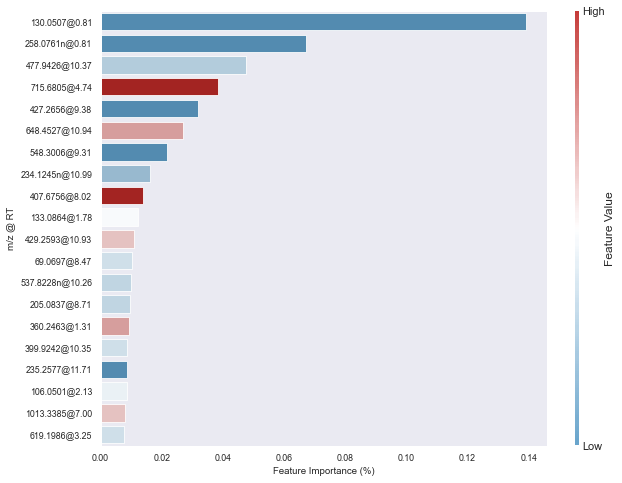

In [29]:
%matplotlib inline
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.pyplot as plt
from shap.plots.colors import red_blue
from matplotlib.cm import coolwarm
sns.set_style("dark")
sns.set_context("paper")
fig, ax = plt.subplots(1,1, figsize=(10,8))
cmap = sns.cubehelix_palette(light=1)
sns.barplot(x=feature_importance, y=formatted_colnames, ax=ax, palette=plot_cmap(scaled_colors), orient='h')
ax.set_xlabel("Feature Importance (%)")
ax.set_ylabel("m/z @ RT")


import matplotlib.cm as cm
m = cm.ScalarMappable(cmap=legend_cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ticks=[0, 1], aspect=1000)
cb.set_ticklabels(["Low", "High"])
cb.set_label("Feature Value", size=12, labelpad=0)
cb.ax.tick_params(labelsize=11, length=0)
cb.set_alpha(1)
cb.outline.set_visible(False)
bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
cb.ax.set_aspect((bbox.height - 0.9) * 20)

plt.savefig("SHAP_all.svg", bbox_inches='tight')

In [30]:
feature_importance[:20]

array([0.13897375, 0.06713678, 0.04766248, 0.03848226, 0.03171642,
       0.02704218, 0.02162485, 0.01607201, 0.01373183, 0.01234606,
       0.01105575, 0.01040437, 0.01005649, 0.00974021, 0.00931169,
       0.00875103, 0.00864057, 0.00857587, 0.00804037, 0.00763636])